In [144]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import pandas as pd
import pickle # Serve para salvar o modelo treinado

In [145]:
# Parametros de configuração do plot
plt.rcParams['figure.figsize'] = (10,6)
plt.style.use('dark_background')

## Dataset de teste

In [146]:
# Gerando os dados para treinamento
# n_samples -> quantidade de amostras
# noise -> ruído
x, y = datasets.make_moons(n_samples=1000, noise=0.05)

In [147]:
x.shape, y.shape
print(f'{x.shape = } {y.shape = }')

x.shape = (1000, 2) y.shape = (1000,)


In [148]:
pd.DataFrame({'x_1': x[:, 0], 'x_2': x[:, 1], 'y': y}).head()

,x_1,x_2,y
0,1.838549,-0.104539,1
1,0.899292,0.466621,0
2,-0.877282,0.501678,0
3,2.040523,0.313434,1
4,-0.956106,0.152780,0


In [149]:
unique = np.unique(y, return_counts=True)
for label, qt_label in zip(unique[0], unique[1]):
  print(f'Label: {label}\t tipo: {type(label)}\t Quantidade: {qt_label}')

Label: 0	 tipo: <class 'numpy.int64'>	 Quantidade: 500
Label: 1	 tipo: <class 'numpy.int64'>	 Quantidade: 500


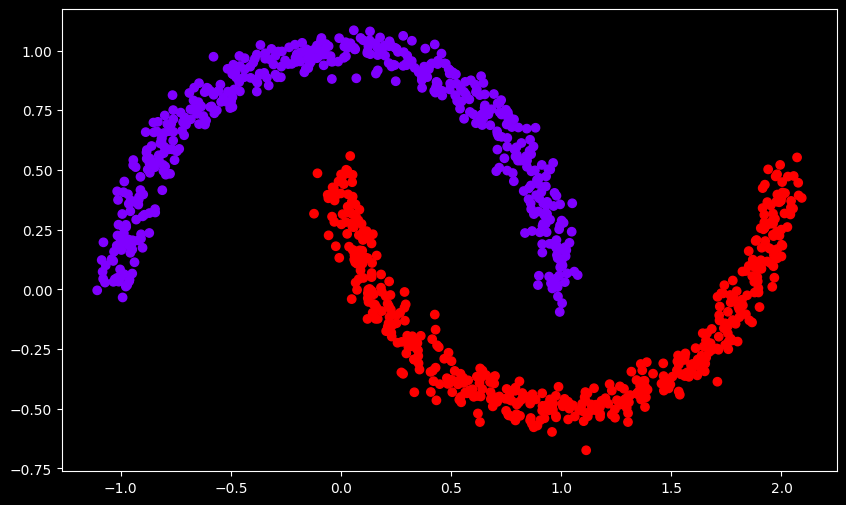

In [150]:
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='rainbow')

# Modelo

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pickle

# ### Etapas:
# 
# 1. Inicialização dos pesos e bias
# 2. FeedForward
# 3. Calculo da perda
# 4. Backpropagation
# 5. Fit

# %%
class RnModel:

  def __init__(self, x: np.ndarray, y: np.ndarray, hidden_neurons: int = 10, 
               output_neurons: int = 1, random_seed: int | None = None, activation: str = 'sigmoid'):
    """
      Inicializa uma rede neural simples com uma camada oculta.

      Parâmetros:
      ----------
      x : np.ndarray
          Matriz de entrada com formato (n_amostras, n_features).
      y : np.ndarray
          Vetor ou matriz de rótulos com formato (n_amostras,) ou (n_amostras, n_outputs).
      hidden_neurons : int
          Número de neurônios na camada oculta.
      output_neurons : int
          Número de neurônios na camada de saída.
      random_seed : int | None
          Valor para reprodutibilidade da inicialização aleatória dos pesos.
      activation : str
          Nome da função de ativação usada na camada oculta. 
          Opções: 'tanh', 'relu', 'sigmoid'.

      Descrição:
      ----------
      Este construtor configura a estrutura básica da rede:
        - Valida as dimensões de entrada.
        - Define os tamanhos das camadas.
        - Inicializa pesos e bias com pequenas variações aleatórias (método Xavier).
        - Define a função de ativação escolhida em activation.
        - Armazena parâmetros principais e histórico de perda.
    """

    # Validações simples
    if x.ndim != 2:
      raise ValueError("x deve ser uma matriz 2D com shape (n_amostras, n_features)")
    if y.ndim not in (1, 2):
      raise ValueError("y deve ser um vetor 1D ou matriz 2D de rótulos")

    self.x = x
    # garantir formato coluna para y quando saída única
    self.y = y.reshape(-1, 1) if (y.ndim == 1 and output_neurons == 1) else y

    self.hidden_neurons = int(hidden_neurons)
    self.output_neurons = int(output_neurons)
    
    # dimensões que é o Nº de entradas é o numero de entradas (colunas na entrada x)
    self.input_neurons = x.shape[1]

    # inicialização de pesos (pequenos valores aleatórios) e biases (zeros)
    # Xavier Inicialization -> Variancia dos pesos igual em todas as camadas
    rng = np.random.RandomState(random_seed)
    
    # Camada de entrada para a camada oculta
    self.w1 = rng.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)  # (n_features, hidden)
    self.b1 = np.zeros((1, self.hidden_neurons)) # (1, hidden)
    
    # Camada oculta para a camada de saída                     
    self.w2 = rng.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.hidden_neurons)  # (hidden, output)
    self.b2 = np.zeros((1, self.output_neurons))  # (1, output)
    self.z1 = 0
    self.f1 = 0
    self.activation = activation.lower()

    self.model_dist = {
      'w1': self.w1,
      'b1': self.b1,
      'w2': self.w2,
      'b2': self.b2,
      'random_seed': random_seed,
      'activation': self.activation
    }

    # histórico de perda
    self.loss_history = []

  # -------------------- Funções auxiliares --------------------

  def showPlot(self, predictions):
    """
      Plota um scatter 2D das amostras coloridas pelas predições.

      Parâmetros:
      ----------
      predictions : np.ndarray
          Vetor de rótulos ou previsões com comprimento igual ao número de amostras (n_amostras,).

      Retorna:
      --------
      None

      Descrição:
      ----------
      Exibe um gráfico de dispersão usando as duas primeiras características de entrada
      (x[:, 0] e x[:, 1]) e colore cada ponto de acordo com 'predictions'. A função
      exige que os dados de entrada tenham exatamente 2 features.
    """
    if self.x.shape[1] != 2:
      raise ValueError("showPlot só funciona para entradas 2D com shape (n_amostras, 2)")

    plt.scatter(self.x[:, 0], self.x[:, 1], s=50, c=predictions, cmap='rainbow', alpha=0.7)
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title('Predições (showPlot)')
    plt.show()


  def activation_forward(self, z):
    """Aplica a função de ativação selecionada."""
    if self.activation == "tanh":
      return np.tanh(z)
    elif self.activation == "relu":
      return np.maximum(0, z)
    elif self.activation == "sigmoid":
      return 1 / (1 + np.exp(-z))
    else:
      raise ValueError(f"Função de ativação '{self.activation}' não suportada.")
      
  # ------------------------------------------------------------

  def activation_derivative(self, z):
    """Calcula a derivada da função de ativação selecionada."""
    if self.activation == "tanh":
      return (1 - np.power(np.tanh(z), 2))
    elif self.activation == "relu":
      return (z > 0).astype(float)
    elif self.activation == "sigmoid":
      s = 1 / (1 + np.exp(-z))
      return s * (1 - s)
    else:
      raise ValueError(f"Função de ativação '{self.activation}' não suportada.")

  def forward(self, x: np.ndarray) -> np.ndarray:
    """
      Realiza a etapa de propagação direta (forward pass).

      Parâmetros:
      ----------
      x : np.ndarray
          Entradas da rede com formato (n_amostras, n_features).

      Retorna:
      --------
      np.ndarray
          Saída da rede após a função activations escolhida .

      Descrição:
      ----------
      Executa o fluxo de dados da entrada até a saída:
        1. Calcula z1 = x·w1 + b1.
        2. Aplica a função de ativação tanh: f1 = tanh(z1).
        3. Calcula z2 = f1·w2 + b2.
        4. Aplica a função softmax para converter as saídas em probabilidades.
    """
    # Equação da reta (1)
    # Multiplicação de matrizes + bias 
    self.z1 = x.dot(self.w1) + self.b1

    # Função de ativação (1)
    self.f1 = self.activation_forward(self.z1)

    # Equação da reta (2)
    z2 = self.f1.dot(self.w2) + self.b2
    
    # Se for problema binário (1 neurônio na saída), use sigmoid
    if self.output_neurons == 1:
        return self.activation_forward(z2)
    else:
    # Softmax (Probabilidade de cada classe) -> Função de ativação (2)
        exp_values = np.exp(z2)
        softmax = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
        return softmax


  def loss(self, output):
    """
      Calcula a função de perda (erro) utilizando entropia cruzada.

      Parâmetros:
      ----------
      output : np.ndarray
          Saídas previstas da rede (probabilidades de cada classe).

      Retorna:
      --------
      float
          Valor médio da perda para a época atual.

      Descrição:
      ----------
      Mede o erro entre as previsões do modelo e os rótulos corretos.
      A função de entropia cruzada penaliza previsões com baixa probabilidade
      para as classes verdadeiras.
    """
    if self.output_neurons == 1:
        # Binary Cross-Entropy
        eps = 1e-9
        return -np.mean(self.y * np.log(output + eps) + (1 - self.y) * np.log(1 - output + eps))
    else:
        # Categorical Cross-Entropy
        predictions = np.zeros(self.y.shape[0])
        for i, correct_index in enumerate(self.y.astype(int).ravel()):
            predictions[i] = output[i][correct_index]
        log_prob = -np.log(predictions + 1e-9)
        return np.mean(log_prob)


  def backpropagation(self, softmax: np.ndarray, learning_rate: float = 0.1):
    """
      Realiza o processo de retropropagação do erro (backpropagation).

      Parâmetros:
      ----------
      softmax : np.ndarray
          Saídas obtidas da etapa de forward.
      learning_rate : float
          Taxa de aprendizado usada para ajustar os pesos.

      Descrição:
      ----------
      Calcula os gradientes do erro em relação aos pesos e bias,
      e ajusta os parâmetros do modelo com base no gradiente descendente:
        - Calcula os deltas das camadas (delta2 e delta1).
        - Obtém gradientes dw e db.
        - Atualiza pesos e bias com o fator de aprendizado definido.
    """
    # Cópia da saída do softmax
    delta2 = np.copy(softmax)
    
    # Corrigido: cálculo correto da diferença entre saída prevista e real
    delta2[range(self.x.shape[0]), self.y] -= 1

    # Gradientes da camada de saída
    dw2 = (self.f1.T).dot(delta2)
    db2 = np.sum(delta2, axis = 0, keepdims=True)

    # Gradientes da camada oculta (derivada da tanh)
    delta1 = delta2.dot(self.w2.T) * self.activation_derivative(self.z1)
    dw1 = (self.x.T).dot(delta1)
    db1 = np.sum(delta1, axis = 0, keepdims=True)

    # Atualização dos pesos e bias
    self.w1 += -learning_rate * dw1  # 'w1 = w1 - self.learning_rate*dw1'
    self.w2 += -learning_rate * dw2 
    self.b1 += -learning_rate * db1 
    self.b2 += -learning_rate * db2 
    


  def fit(self, learning_rate: float = 0.1, epochs: int = 1000):
    """
      Treina o modelo usando o algoritmo de descida do gradiente (Gradient Descent).

      Parâmetros:
      ----------
      learning_rate : float
          Taxa de aprendizado que define o tamanho do passo na atualização dos pesos.
      epochs : int
          Número de iterações (épocas) de treinamento.

      Retorna:
      --------
      np.ndarray
          Predições finais do modelo após o término do treinamento.

      Descrição:
      ----------
      Para cada época:
        1. Executa a propagação direta (forward).
        2. Calcula a perda média (erro).
        3. Atualiza pesos e bias pela retropropagação.
        4. Mede a acurácia com base nas predições atuais.
      Exibe periodicamente métricas de desempenho.
    """
    for epoch in range(epochs):
      outputs = self.forward(self.x)
      loss = self.loss(outputs)
      self.loss_history.append(loss)
      self.backpropagation(outputs, learning_rate)

      # Calculo de acuracia
      y_true = self.y.ravel()
      if self.output_neurons == 1:
        prediction = (outputs > 0.5).astype(int).ravel()
      else:
        prediction = np.argmax(outputs, axis=1)
      correct = np.sum(prediction == y_true)
      accuracy = correct / len(y_true)
      

      # Correção na condição de exibição de progresso
      if (epoch + 1) % max(1, (epochs // 10)) == 0:
        print(f'Epoch: [{epoch+1} / {epochs}] Accuracy: {accuracy:.3f} Loss: {loss:.4f} Correct: {correct} Total: {self.y.shape[0]}')
    
    return prediction




### Treinamento

In [197]:
modelo = RnModel(x, y, hidden_neurons=10, output_neurons=2, random_seed=8, activation='sigmoid')
result = modelo.fit(learning_rate=0.001, epochs=1000)


Epoch: [100 / 1000] Accuracy: 0.886 Loss: 0.2533 Correct: 886 Total: 1000
Epoch: [200 / 1000] Accuracy: 0.896 Loss: 0.2410 Correct: 896 Total: 1000
Epoch: [300 / 1000] Accuracy: 0.901 Loss: 0.2207 Correct: 901 Total: 1000
Epoch: [400 / 1000] Accuracy: 0.924 Loss: 0.1736 Correct: 924 Total: 1000
Epoch: [500 / 1000] Accuracy: 0.951 Loss: 0.1255 Correct: 951 Total: 1000
Epoch: [600 / 1000] Accuracy: 0.969 Loss: 0.0932 Correct: 969 Total: 1000
Epoch: [700 / 1000] Accuracy: 0.981 Loss: 0.0726 Correct: 981 Total: 1000
Epoch: [800 / 1000] Accuracy: 0.993 Loss: 0.0586 Correct: 993 Total: 1000
Epoch: [900 / 1000] Accuracy: 0.995 Loss: 0.0485 Correct: 995 Total: 1000
Epoch: [1000 / 1000] Accuracy: 0.997 Loss: 0.0408 Correct: 997 Total: 1000


## Teste e Resultados

In [195]:
result

array([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,

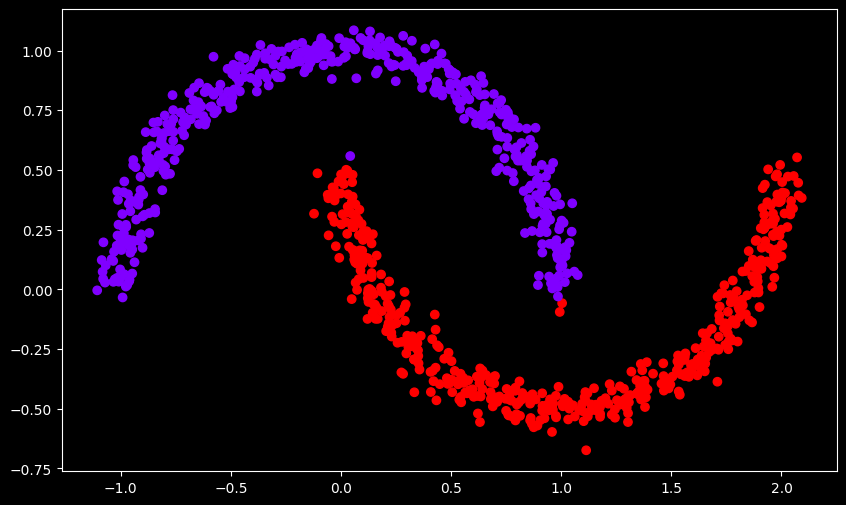

In [196]:
# Em vez do y usei o result
plt.scatter(x[:, 0], x[:, 1], c=result, cmap='rainbow')

### Forçando erro

In [155]:
# Treinando com apenas 50 épocas
modelo = RnModel(x, y, hidden_neurons=10, output_neurons=2, random_seed=8)
result2 = modelo.fit(learning_rate=0.001, epochs=50)

Epoch: [5 / 50] Accuracy: 0.787 Loss: 0.4282
Epoch: [10 / 50] Accuracy: 0.844 Loss: 0.3324
Epoch: [15 / 50] Accuracy: 0.878 Loss: 0.2817
Epoch: [20 / 50] Accuracy: 0.890 Loss: 0.2542
Epoch: [25 / 50] Accuracy: 0.900 Loss: 0.2359
Epoch: [30 / 50] Accuracy: 0.906 Loss: 0.2211
Epoch: [35 / 50] Accuracy: 0.911 Loss: 0.2075
Epoch: [40 / 50] Accuracy: 0.920 Loss: 0.1941
Epoch: [45 / 50] Accuracy: 0.925 Loss: 0.1808
Epoch: [50 / 50] Accuracy: 0.935 Loss: 0.1675


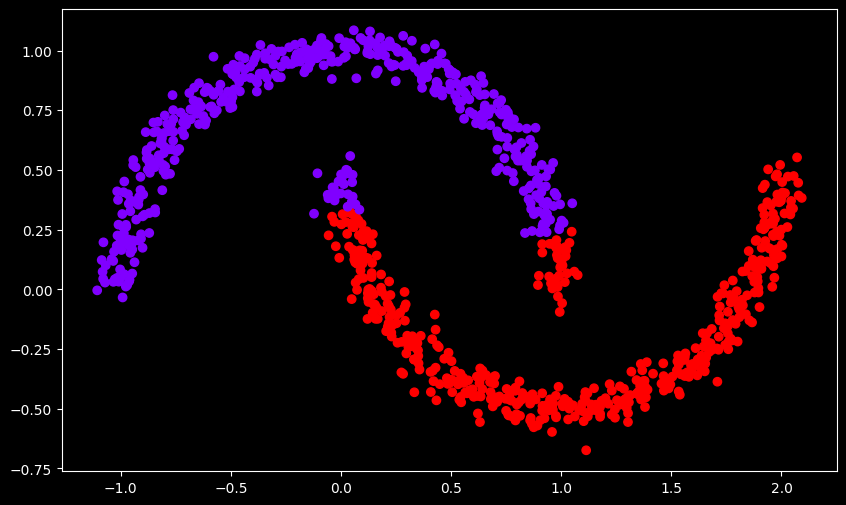

In [156]:
# Em vez do y usei o result
plt.scatter(x[:, 0], x[:, 1], c=result2, cmap='rainbow')

### Teste e Resultados - Teste 2

In [157]:
x_, y_ = datasets.make_blobs(n_samples=400, n_features=2, centers=4, random_state=10, cluster_std=0.9, shuffle=True)

In [158]:
x_.shape, y_.shape

((400, 2), (400,))

In [159]:
np.unique(y_, return_counts=True)

(array([0, 1, 2, 3]), array([100, 100, 100, 100], dtype=int64))

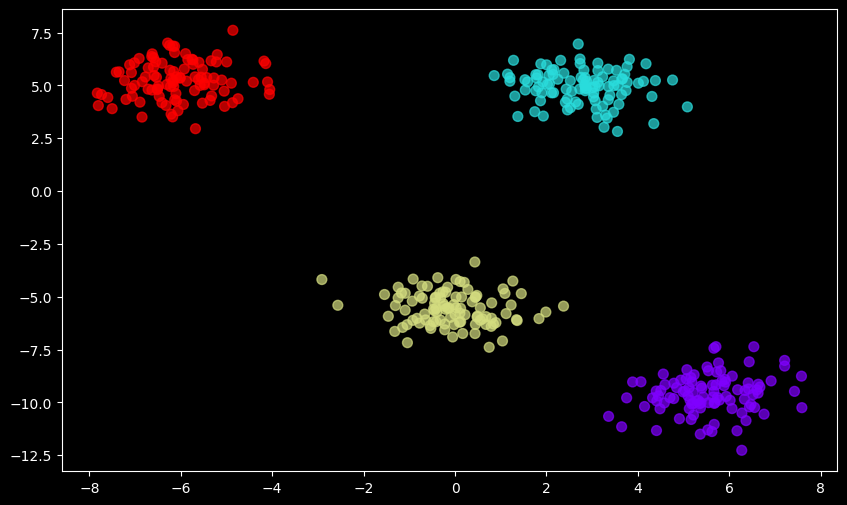

In [160]:
plt.scatter(x_[:, 0], x_[:, 1], s=50, c=y_, cmap='rainbow', alpha=0.7)

In [161]:
hidden_neurons = 10 # 10 neuronios na camada intermediaria/oculta
output_neurons = 4 # Agora são 4 classes, ou seja 4 neuronios na camada de saida
random_seed = 8 
learning_rate = 0.001 # taxa de aprendizado
epochs = 500 # epocas de treinamento

In [162]:
modelo = RnModel(x_, y_, hidden_neurons=hidden_neurons, output_neurons=output_neurons, random_seed=random_seed)
result2 = modelo.fit(learning_rate=learning_rate, epochs=epochs)

Epoch: [50 / 500] Accuracy: 0.993 Loss: 0.0383
Epoch: [100 / 500] Accuracy: 0.993 Loss: 0.0273
Epoch: [150 / 500] Accuracy: 0.995 Loss: 0.0227
Epoch: [200 / 500] Accuracy: 0.995 Loss: 0.0201
Epoch: [250 / 500] Accuracy: 0.995 Loss: 0.0183
Epoch: [300 / 500] Accuracy: 0.995 Loss: 0.0168
Epoch: [350 / 500] Accuracy: 0.995 Loss: 0.0157
Epoch: [400 / 500] Accuracy: 0.998 Loss: 0.0147
Epoch: [450 / 500] Accuracy: 0.998 Loss: 0.0138
Epoch: [500 / 500] Accuracy: 0.998 Loss: 0.0129


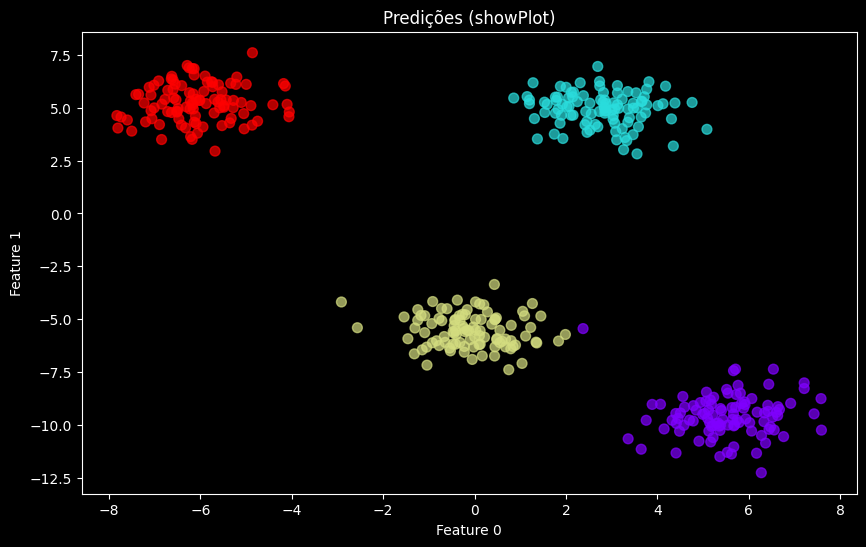

In [163]:
modelo.showPlot(result2)

In [164]:
with open('model.pkl', 'wb') as f:
  pickle.dump(modelo, f)